In [1]:
#Neccessary Libraries
import pandas_datareader.data as web
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.optimize import minimize
from math import e

In [2]:
#Specifies the start and end date for the efficient frontier
start = datetime.datetime(2017,10,1)
end = datetime.datetime(2022,10,1)

In [3]:
#The stocks that will make up the portfolio
msft = web.DataReader('MSFT','yahoo',start,end)
amt = web.DataReader('AMT','yahoo',start,end)
v = web.DataReader('V','yahoo',start,end)
zts = web.DataReader('ZTS','yahoo',start,end)
txrh = web.DataReader('TXRH','yahoo',start,end)
mkc = web.DataReader('MKC','yahoo',start,end)

In [4]:
#Concatenates the stock prices
stocks = pd.concat([msft['Close'],amt['Close'],v['Close'],zts['Close'],mkc['Close']], axis = 1)
stocks.columns = ['MSFT','AMT','V','ZTS','MKC']
print(stocks)

                  MSFT         AMT           V         ZTS        MKC
Date                                                                 
2017-10-02   74.610001  135.860001  105.440002   63.750000  49.884998
2017-10-03   74.260002  136.660004  105.589996   63.590000  49.040001
2017-10-04   74.690002  138.839996  105.309998   63.570000  49.884998
2017-10-05   75.970001  139.250000  106.239998   63.750000  49.160000
2017-10-06   76.000000  139.110001  106.730003   63.750000  49.090000
...                ...         ...         ...         ...        ...
2022-08-31  261.470001  254.050003  198.710007  156.529999  84.070000
2022-09-01  260.399994  257.640015  200.130005  159.410004  84.790001
2022-09-02  256.059998  250.850006  197.759995  156.979996  83.050003
2022-09-06  253.250000  254.179993  198.639999  156.839996  82.199997
2022-09-07  258.089996  259.500000  200.419998  160.399994  85.000000

[1242 rows x 5 columns]


In [5]:
#Produces the Returns
returns = stocks/stocks.shift(1)
#Produces the Log Returns
logReturns = np.log(returns)

In [6]:
##Gets the Sharpe Ratio 

#This is for number of portfolios
noOfPortfolios = 100000

#In np.zeros the integer is the number of stocks in portfolio
weight = np.zeros((noOfPortfolios,5))
expectedReturn = np.zeros(noOfPortfolios)
expectedVolatility = np.zeros(noOfPortfolios)
sharpeRatio = np.zeros(noOfPortfolios)

meanLogRet = logReturns.mean()
Sigma = logReturns.cov()

for k in range(noOfPortfolios):
    
    # Generate random weight vector
    w = np.array(np.random.random(5))
    w = w/ np.sum(w)
    weight[k,:] = w
    
    # Expected Log Return
    expectedReturn[k] = np.sum(meanLogRet * w)
    
    # Expected Volatility
    expectedVolatility[k] = np.sqrt(np.dot(w.T, np.dot(Sigma,w)))
    
    #Sharpe Ratio
    sharpeRatio[k] = expectedReturn[k]/ expectedVolatility[k]
    

In [7]:
#Sharpe Ratio Maximization
maxIndex = sharpeRatio.argmax()
weight[maxIndex,:]

array([0.61530453, 0.0444465 , 0.00534882, 0.30146403, 0.03343612])

In [8]:
#Minimize the negative sharpe ratio
def negativeSR(w):
    w = np.array(w)
    R = np.sum(meanLogRet * w)
    V = np.sqrt(np.dot(w.T, np.dot(Sigma,w)))
    SR = R/V
    return -1*SR

def checkSumToOne(w):
    return np.sum(w) - 1

#These are the initial weights
w0 = [0.2,0.2,0.2,0.2,0.20]

#The tuple count should be the same as the count of stocks in portfolio
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1))
constraints = ({'type':'eq','fun':checkSumToOne})
w_opt = minimize(negativeSR,w0,method = 'SLSQP',bounds = bounds,constraints = constraints)
w_opt

     fun: -0.05440136107007718
     jac: array([-0.00016268,  0.00136134,  0.01339505,  0.00042211, -0.00041164])
 message: 'Optimization terminated successfully'
    nfev: 60
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([6.59355970e-01, 0.00000000e+00, 7.80625564e-18, 2.96834712e-01,
       4.38093177e-02])

In [9]:
#Optimal Weights
w_opt.x

array([6.59355970e-01, 0.00000000e+00, 7.80625564e-18, 2.96834712e-01,
       4.38093177e-02])

In [10]:
def minimizeMyVolatility(w):
    w = np.array(w)
    v = np.sqrt(np.dot(w.T, np.dot(Sigma,w)))
    return v

In [11]:
def getReturn(w):
    w = np.array(w)
    R = np.sum(meanLogRet*w)
    return R

In [12]:
#Creates the Efficient Frontier Line

#Change the linspace function to the top part of the y-axis
returns = np.linspace(0,0.0013,50)
volatility_opt = []
for R in returns:
    # find best volatility
    constraints = ({'type':'eq','fun':checkSumToOne},
                  {'type':'eq','fun': lambda w: getReturn(w) - R})
    opt = minimize(minimizeMyVolatility,w0,method = 'SLSQP',bounds = bounds,constraints = constraints)
    
    # Save my optimal volatility
    volatility_opt.append(opt['fun'])

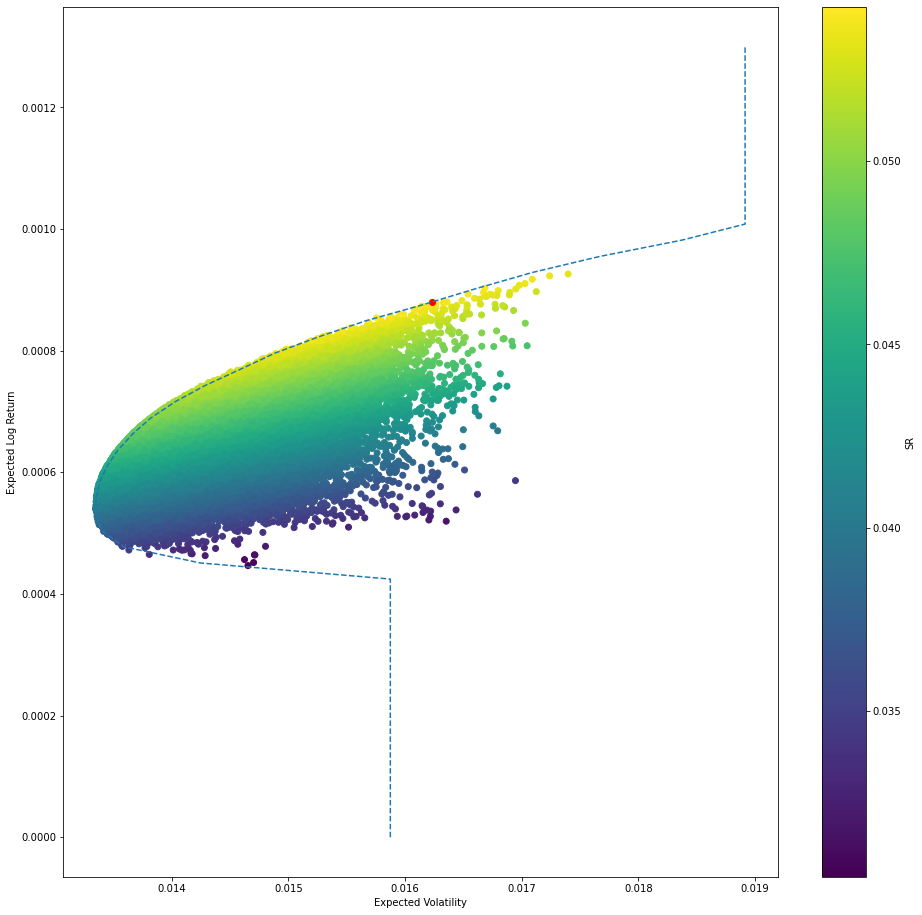

In [13]:
#Scatterplot Returns V. Volatility
plt.figure(figsize = (16,16))
plt.scatter(expectedVolatility,expectedReturn, c = sharpeRatio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Return')
plt.colorbar(label = 'SR')
plt.scatter(expectedVolatility[maxIndex],expectedReturn[maxIndex],c = 'red')
plt.plot(volatility_opt,returns,'--')
plt.show()

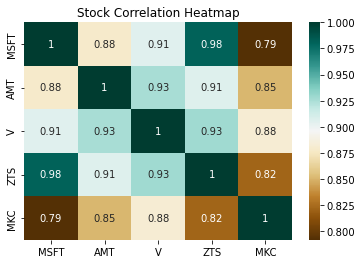

In [14]:
#This Creates the Covariance Matrix of the Stocks in the portfolio
sn.heatmap(stocks.corr(),annot=True,cmap='BrBG')
plt.title('Stock Correlation Heatmap')
print('')

In [15]:
#Portfolio Weights Tables with: Volatilities, Log Returns, Returns, and Stocks
portfolioConstruct = pd.DataFrame({'Sharpe_Return':sharpeRatio,
                                  'Log_Volatility':expectedVolatility,
                                  'Log_Return':expectedReturn,
                                   'Sharpe_Ratio':sharpeRatio,
                                  'Return':[e ** i for i in expectedReturn],
                                  'Volatility':[e ** i for i in expectedVolatility]
                                  })
print(portfolioConstruct)

       Sharpe_Return  Log_Volatility  Log_Return  Sharpe_Ratio    Return  \
0           0.045568        0.015875    0.000723      0.045568  1.000724   
1           0.044635        0.013666    0.000610      0.044635  1.000610   
2           0.051347        0.014949    0.000768      0.051347  1.000768   
3           0.041185        0.013741    0.000566      0.041185  1.000566   
4           0.043760        0.014198    0.000621      0.043760  1.000622   
...              ...             ...         ...           ...       ...   
99995       0.045094        0.013599    0.000613      0.045094  1.000613   
99996       0.049305        0.014032    0.000692      0.049305  1.000692   
99997       0.045103        0.014306    0.000645      0.045103  1.000645   
99998       0.039525        0.014769    0.000584      0.039525  1.000584   
99999       0.043115        0.013442    0.000580      0.043115  1.000580   

       Volatility  
0        1.016002  
1        1.013759  
2        1.015062  
3      

In [16]:
portfolioConstruct = portfolioConstruct.sort_values(by = ['Sharpe_Return'],ascending = False)
portfolioConstruct['index_column'] = portfolioConstruct.index

In [ ]:
for i in portfolioConstruct.index:
    print(weight[i],portfolioConstruct['Sharpe_Ratio'][i] )
    

[0.61530453 0.0444465  0.00534882 0.30146403 0.03343612] 0.05420063001469806
[0.606376   0.02323077 0.00248508 0.24239658 0.12551157] 0.05419466829436007
[0.70883121 0.03559169 0.01171033 0.20588176 0.03798501] 0.05411459270370526
[0.63807363 0.09334206 0.00120063 0.22618413 0.04119955] 0.05409216455002423
[0.66010099 0.04081479 0.02265378 0.25861462 0.01781582] 0.05399634694224182
[0.63826438 0.03723131 0.02449429 0.24848676 0.05152326] 0.05398418112380962
[0.60876947 0.08105902 0.01200045 0.27696171 0.02120935] 0.05397929296359248
[0.68182721 0.01827917 0.00816786 0.14934333 0.14238244] 0.05396504232421946
[0.66306434 0.00763577 0.02723812 0.21285864 0.08920313] 0.05396349692976087
[0.57088756 0.05553207 0.0118673  0.24264174 0.11907133] 0.05391647320366532
[0.62345702 0.10101086 0.01164186 0.23012733 0.03376294] 0.053905643177286335
[0.55385231 0.03745347 0.01924795 0.3026264  0.08681987] 0.0538974195851794
[0.65533593 0.07003462 0.00386941 0.14498913 0.12577091] 0.05389309484779551